In [1]:
from __future__ import division, print_function
import numpy, pylab, math
import icecube
from icecube import dataio
from icecube import dataclasses
from icecube import CascadeVariables
import os
%matplotlib inline

In [2]:
gcd=dataio.I3File("/data/sim/IceCube/2011/filtered/level2/neutrino-generator/10099/00000-00999/GeoCalibDetectorStatus_IC86.55697_corrected_V2.i3.gz")


In [3]:
gcd.rewind()
fr=gcd.pop_frame()
geo=fr.Get("I3Geometry")


In [9]:
NFiles=1
bgFilesI3=[]
bgDir="/data/user/lwille/dat/2013NuTauComparison/"

bgFiles=os.listdir(bgDir)
for i in bgFiles:
    if(i.find(".i3.bz2")>0):
        bgFilesI3.append(i)


bgFilesI3=bgFilesI3[0:NFiles]

In [36]:
Count=0    
NoCascadesBG=0
Distances=[]
Waveforms=[]
Energies=[]
Times=[]
Charges=[]
MaxWFTimes=[]
BinWidths=[]

EnergyLimLow=5e3
EnergyLimHigh=1e5

for bgFile in bgFilesI3:
    Count=Count+1
    print("opening "+bgFile+",  "+str(Count)+" of " + str(len(bgFilesI3)))
    bgFile=dataio.I3File(bgDir+bgFile)
    bgFile.rewind()
    numevents=0
    while(bgFile.more()):
        #pop a frame
        numevents=numevents+1
        if(numevents%100==0):
            print(numevents)
        fr=bgFile.pop_physics()

        #grab the weight dict and event weight
        WeightDict=fr.Get("I3MCWeightDict")
        Weight=(365*24*3600)*1.0e-8*pow(WeightDict["PrimaryNeutrinoEnergy"], -2)*WeightDict["OneWeight"]/(WeightDict["NEvents"]*len(bgFilesI3))

        #Find the cascade center
        if not fr.Has("CascadeLlhVertexFit_L2") :
            NoCascadesBG=NoCascadesBG+1
            continue

        if( WeightDict["PrimaryNeutrinoEnergy"]<EnergyLimLow) or (WeightDict["PrimaryNeutrinoEnergy"]>EnergyLimHigh):    
            continue
        csc=fr.Get('CascadeLlhVertexFit_L2')
        cscpos=csc.pos

        #Get the waveforms
#        rd=fr.Get('In')
        wf=fr.Get('CalibratedWaveformsHLCATWD')
        DistancesThisEvt=[]
        WaveformsThisEvt=[]
        EnergiesThisEvt=[]
        TimesThisEvt=[]
        ChargesThisEvt=[]
        BinWidthsThisEvt=[]
        for om, wf_series in wf:
            for w in wf_series:
                if(w.status==0):
                    DOMPos=geo.omgeo[om].position
                    DistancesThisEvt.append((cscpos-DOMPos).r)
                    WaveformsThisEvt.append(w.waveform)
                    TimesThisEvt.append(w.time)
                    ChargesThisEvt.append(sum(w.waveform))
                    BinWidthsThisEvt.append(w.bin_width)
                    break
            Energies.append(csc.energy)
            Distances.append(DistancesThisEvt)
            Waveforms.append(WaveformsThisEvt)
            Charges.append(ChargesThisEvt)
            Times.append(TimesThisEvt)
            BinWidths.append(BinWidthsThisEvt)
            MaxWFTimes.append(TimesThisEvt[numpy.argmax(ChargesThisEvt)])

            

opening l4_000601-000700.i3.bz2,  1 of 1
100
200
300
400
500
600
700
800
900
1000
1100


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000


[]

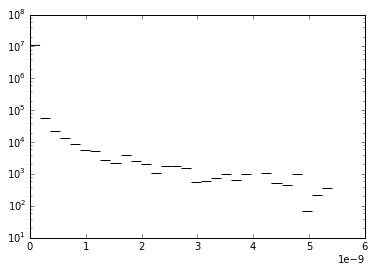

In [37]:
wfamps=[]
count=0
for wfe in Waveforms:
    count=count+1
    if(count%1000==0):
        print(count)
    for wf in wfe:
        wfamps.append(max(wf))
pylab.hist(wfamps,bins=30)
pylab.semilogy()

In [38]:
TimeShifts=[]
for tindex in range(0,len(Times)):
    StartTime=numpy.min(Times[tindex])
    TimeShifts.append((Times[tindex]-StartTime)/BinWidths[tindex])
    

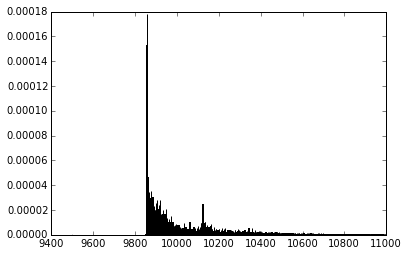

In [39]:
TimesFlat=[item for sublist in Times for item in sublist]
ChargesFlat=[item for sublist in Charges for item in sublist]
pylab.hist(TimesFlat, weights=ChargesFlat,bins=numpy.arange(9500,11000,1))

pylab.show()

In [44]:
therange=numpy.arange(0,128)

W_Normd=[]
W_Sum=[]

ylimlo=-40
ylimhi=120

DistanceLims=numpy.arange(0,250,25)
AveWFs=[]
for dis in range(0,len(DistanceLims)-1):
    NWF=0
    TotCharge=0
    WFLength=500
    AveWF=numpy.zeros(WFLength)
    count=0


    for i in range(0,len(Waveforms)):
        count=count+1
        if(count==1000):
            break
        for j in range(0,len(Waveforms[i])):
            if(DistanceLims[dis]<Distances[i][j] and DistanceLims[dis+1]>Distances[i][j]) and len(Waveforms[i][j])==128:
                Shift=int(TimeShifts[i][j])
                if(Shift<WFLength):
                    Charge=0
                    for w in range(0,min(128,(WFLength-Shift))):
                        AveWF[w+Shift]+=numpy.array(Waveforms[i][j][w])
                        Charge+=Waveforms[i][j][w]
                    TotCharge+=Charge
                    NWF+=1
    AveWFs.append(AveWF/TotCharge)

    print(NWF,TotCharge)
    

616 3.00337264756e-05
1784 2.1871110356e-05
6674 1.19347512301e-05
14518 1.26137928025e-05
23455 6.7392878417e-06
37987 5.77016663519e-06
39140 2.75510971067e-06
34015 1.36596671942e-06
27855 1.01045221344e-06


In [46]:
WFDictionary={}
AveWFs[0]=AveWFs[1]
for i in range(0, len(AveWFs)):
    WFDictionary[DistanceLims[i]]=AveWFs[i]
    

In [47]:
import cPickle
KernelsFile=open("DOMKernelsATWD.dat",'w')
cPickle.dump(WFDictionary,KernelsFile)
KernelsFile.close()